## First, you need to download the ROM for the game you wanna use as an Environment
- https://wowroms.com/en/roms/sega-genesis-megadrive/download-street-fighter-ii-special-champion-edition-europe/26496.html

In [13]:
import retro  ##This will be the base for us to play StreetFighter or any game on our system anad create an Environment.
import time  ##To make changes in the speed of Rendering.

In [14]:
##So if you wanna look at different games that are available via 'gym-retro'
retro.data.list_games()  ##We are going to be playing 'StreetFighterIISpecialChampionEdition-Genesis' here.

In [15]:
##To import your Game ROM to the Retro, Recommended to use in the ROM Directory.
## 'python -m retro.import .'

## Testing the Environment

In [16]:
##Now that our ROM has been loaded in the retro, let's test the Environment

In [19]:
##Like we do usually
env = retro.make('StreetFighterIISpecialChampionEdition-Genesis')  ##This is the name of the ROM, also specified in the game list above.

In [18]:
##RuntimeError: Cannot create multiple emulator instances per process, make sure to call env.close() on each environment before creating a new one
##If you are getting this error then just close the environment and create an Instance again.
env.close()

In [20]:
env.observation_space  ##As you can se it is an Image with values varying from 0 to 255

Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
 

In [21]:
env.action_space  ##It is a MultiBinary data type that contains our different actions

MultiBinary(12)

In [22]:
##An action would be like, so this would be our one action.
[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]

In [23]:
env.action_space.sample()

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int8)

In [25]:
##Now let's test our game
state = env.reset()  ##To get the initial Observations
done = False

for game in range(1):   ##We are gonna look at just one game
    while not done:
        if done:
            state = env.reset()
        env.render()  ##Rendering the game or Environment
        action = env.action_space.sample()  ##Getting the random actions
        state, reward, done, info = env.step(action)  ##Taking a Step in the Environment using the action.
        time.sleep(0.002)
        print(reward)

In [26]:
info  ##This is the info we got. We can uuse this 'score' instead of the current Reward Function.
##Also note that you can tweek the reward function in a way such as, giving a reward when the Opponent's health deplets, or giving it a negative reward when it's own health deplets.
##You can tweek it however you like.

{'enemy_matches_won': 0,
 'score': 100,
 'matches_won': 0,
 'continuetimer': 0,
 'enemy_health': 151,
 'health': 176}

In [27]:
##So right now we are getting Reward when we score a win. And it will be hard on our AI to learn this.
##Because it will take too much time to train and not an efficient Reward Function. 
##What we can really do is, we can tweek the Reward function in a way that it will give our Agent a Reward when it lands a hit.
##And as you can see that the image size is also (200, 256, 3), we can downgrade it using 'open-cv' to make trainign faster and easier.
##And besides passing the complete frame for training as observations, we can also tweek it and pass only the difference between the previous frame or observation and the latsest one.
##In that case, we will not have to pass in the complete frame where there is a lot of noise or you can say a lot of things that are not even relevant in this usecase we are applying.
##We can just pass the obsevations as the change in the state or frames so that it can capture relative changes that take place during the fight or as the Simulation runs, as youcan also notice that it takes an image for the Observations.

## Preprocessing the Environment
#### Now we need to Preprocess the Environment to make it efficient for our Agent to learn.
#### Let's Create a Custom Environment for StreetFighter.

In [28]:
##So we need to preprocess our image like Grayscaling and compressing ot.
##Calculate the change in the previous and current observation, let's call it 'frame delta'.
##We also need to tweek the Reward function so that we can give the Agent a Reward when it lands a hit on opponent.

In [29]:
##Importing Base Environment Class from 'gym'
from gym import Env

##Importing open-cv for Preprocessing the Image
import cv2

##Importing Spaces for our Action and Observation Space
from gym.spaces import MultiBinary, Box  ##Remember that our 'action_space' is 'MultiBinary' and 'observation_space' is 'Box' type.

##For further Preprocessing
import numpy as np

In [30]:
##Now we can start creating our Custom Environment

In [31]:
class StreetFighter(Env):
    def __init__(self):
        super().__init__()

        ##Specifying Action and Observation Space
        self.action_space = MultiBinary(12)
        self.observation_space = Box(low = 0, high = 255, shape = (84, 84, 1), dtype = np.uint8)

        ##Creating the game instance
        self.game = retro.make('StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions = retro.Actions.FILTERED)
        ##We are going to use the Filtered Acitons, what it basically means is it will give us the Filtered actions in the Environment that are button combinations that are valid,
        ##instead of giving us all of the MultiBinary Values that are Available.
    

    def reset(self):
        obs = self.game.reset()   ##In this reset function we will specify the Previous Observation or Previous Frame.
        
        ##preprocess the Observation(image)
        obs = self.Preprocess(obs)
        self.previous_frame = obs ##Making this Observation as the Previous Frame since it is the Initial Observation.

        ##Creating a Variable to Capture the Score Change since we need to change the Reward Function later.
        ##Right now it gives us the over all or Cumulative score, we need to get the change in the Score as our Reward Function.
        self.score = 0
        return obs
    
    def Preprocess(self, observations):
        grayscale_image = cv2.cvtColor(observations, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(grayscale_image, (84, 84), interpolation = cv2.INTER_CUBIC)
        channels = np.resize(resized_image, (84, 84, 1))
        return channels  ##Now that we have created our Preprocess function, let's use it in 'reset' function to Preprocess the Observations we get.

    def step(self, action):
        ##let's take a Step like we usually do
        obs, reward, done, info = self.game.step(action)
        
        ##applying preprocessing to the Observations
        obs = self.Preprocess(obs)
        
        ##Calculating the Frame Delta or Frame Change
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs  ##As we take the next step the current observations become the previous ones and the observations that we will get after taking the step will become our Current Observations.
        
        ##Calculating Score Delta or the new Reward
        reward = info['score'] - self.score
        self.score = info['score']  ##Same as we did in frame_delta, we get the change by subtracting the previous score from the current score. And then set the current the score as the previous Score that is store it in the self.score variable and the new score will be after taking the next step.
        ##Also remember that we get the Score from the 'info' we get after taking a step.

        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()

    def close(self):
        self.game.close()

In [32]:
##Checking our Obsevations based on the Changes we are making
import matplotlib.pyplot as plt

In [33]:
obs = env.reset()

In [34]:
grayscale_image = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(grayscale_image, (84, 84), interpolation = cv2.INTER_CUBIC)

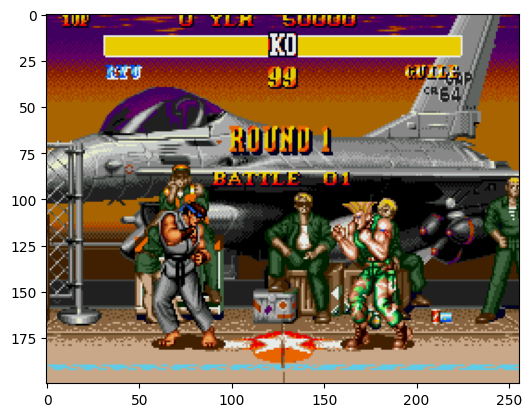

In [35]:
plt.imshow(obs)

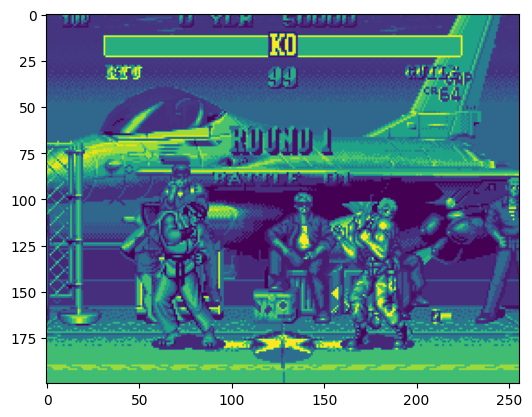

In [36]:
plt.imshow(grayscale_image)

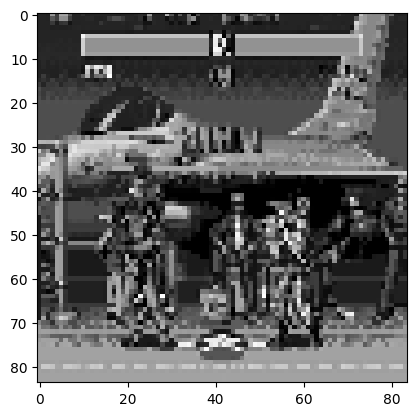

In [37]:
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  ##This is how our Image will look after Preprocessing it.

In [38]:
resized_image.shape  ##But the shape specified in the obseration_space was (200, 256, 3)

(84, 84)

In [39]:
##So to also add a channel or a dimension at the end that will be the channel, that is 1 for Grayscale.
resized_image = np.resize(resized_image, (84, 84, 1))

(84, 84, 1)


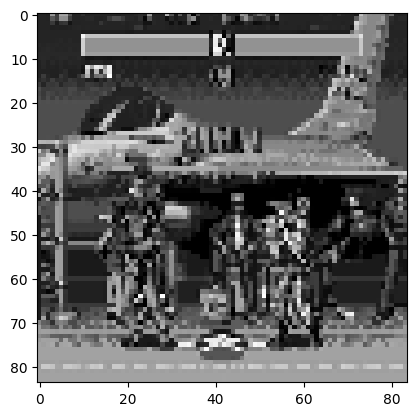

In [40]:
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
print(resized_image.shape)

In [41]:
##Let's test the Environment we just created.

In [42]:
env.close()

In [43]:
env = StreetFighter()

In [44]:
env.observation_space.shape

(84, 84, 1)

In [45]:
env.observation_space

Box([[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], [[[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 ...

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]], (84, 84, 1), uint8)

In [46]:
env.action_space

MultiBinary(12)

In [ ]:
obs = env.reset()

done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.001)
        if reward > 0: 
            print(reward)

In [48]:
##As you can see we are getting the Score everytime our Agent lands a hit and win.

In [49]:
##But one more thing, sometimes this 'frame_delta' that we calculated may end up making our AI not learn very efficiently.

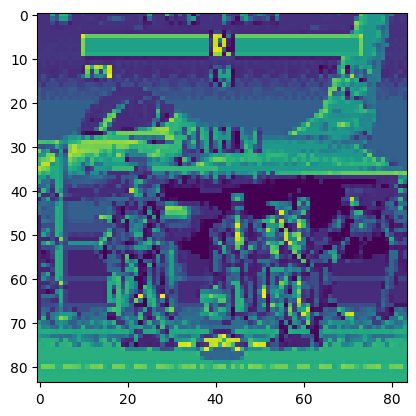

In [50]:
plt.imshow(obs)  ##As you can see this is our Preprocessed Observation

In [51]:
obs = env.reset()

In [55]:
##Let's look at it in more detail
obs, reward, done, info = env.step(env.action_space.sample())  ##let's take a step

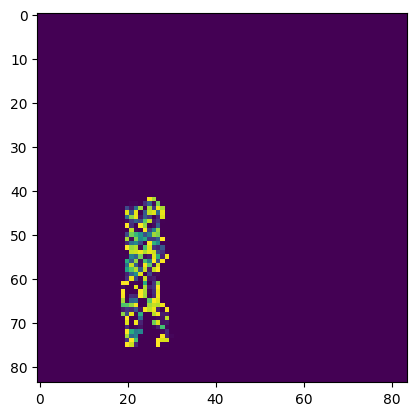

In [56]:
plt.imshow(obs)  ##See we got our Frame Detla, it is only Capturing the Difference between the Frames as we take a step in our Environment.

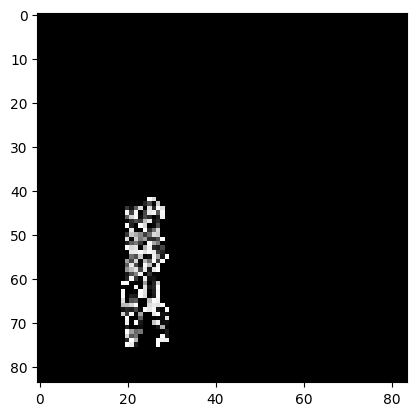

In [57]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

### Creating one more Environment with Original Observations (without frame_delta)

In [58]:
##That is why just in case, let's create one more environment without the Frame Delta. We can just get the code from above.

In [59]:
class StreetFighterNoDelta(Env):
    def __init__(self):
        super().__init__()

        ##Specifying Action and Observation Space
        self.action_space = MultiBinary(12)
        self.observation_space = Box(low = 0, high = 255, shape = (84, 84, 1), dtype = np.uint8)

        ##Creating the game instance
        self.game = retro.make('StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions = retro.Actions.FILTERED)
        ##We are going to use the Filtered Acitons, what it basically means is it will give us the Filtered actions in the Environment that are button combinations that are valid,
        ##instead of giving us all of the MultiBinary Values that are Available.
    

    def reset(self):
        obs = self.game.reset()   ##In this reset function we will specify the Previous Observation or Previous Frame.
        
        ##preprocess the Observation(image)
        obs = self.Preprocess(obs)
        self.previous_frame = obs ##Making this Observation as the Previous Frame since it is the Initial Observation.

        ##Creating a Variable to Capture the Score Change since we need to change the Reward Function later.
        ##Right now it gives us the over all or Cumulative score, we need to get the change in the Score as our Reward Function.
        self.score = 0
        return obs
    
    def Preprocess(self, observations):
        grayscale_image = cv2.cvtColor(observations, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(grayscale_image, (84, 84), interpolation = cv2.INTER_CUBIC)
        channels = np.resize(resized_image, (84, 84, 1))
        return channels  ##Now that we have created our Preprocess function, let's use it in 'reset' function to Preprocess the Observations we get.

    def step(self, action):
        ##let's take a Step like we usually do
        obs, reward, done, info = self.game.step(action)
        
        ##applying preprocessing to the Observations
        obs = self.Preprocess(obs)
        
        ##Calculating Score Delta or the new Reward
        reward = info['score'] - self.score
        self.score = info['score']  ##Same as we did in frame_delta, we get the change by subtracting the previous score from the current score. And then set the current the score as the previous Score that is store it in the self.score variable and the new score will be after taking the next step.
        ##Also remember that we get the Score from the 'info' we get after taking a step.

        return obs, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()

    def close(self):
        self.game.close()

In [60]:
##Now that we are done with creating our Custom Environments. Let's do some Hyperparameter Tuning or Hyperparameter Optimization.

## Hyperparamter Tuning or Hyperparameter Optimization (HPO)

In [61]:
##We will be using Optuna Library for Hyperparameter Tuning.

In [62]:
##What we will basically do is, we will train and evaluate our Model within a range of Hyperparameters for a specified time.
##Optuna will provide us with the best hyperparameter suggestions after the run.
##We will also save our Model after every run and then take the model that is specified as the best acording to Optuna and,
##finetune it further or train it with the best hyperparameters suggested by Optuna.

In [66]:
##For Hyperparamter Tuning
import optuna

##Algorithm to train our Model or Agent
from stable_baselines3 import PPO

##To monitor the Average Reward per Episode and Average Episode Length
from stable_baselines3.common.monitor import Monitor

##To evaluate our Model
from stable_baselines3.common.evaluation import evaluate_policy

##To stack multiple Environments together for training
from stable_baselines3.common.vec_env import VecFrameStack

##Wrapper for the vectorized Environment
from stable_baselines3.common.vec_env import DummyVecEnv

### Let's define a function for Hyperparameter Optimization

In [67]:
def optimize_hyperparameters(trial):
    return {
        'n_steps' : trial.suggest_int('n_steps', 2048, 8192),
        'gamma' : trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range' : trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda' : trial.suggest_uniform('gae_lambda', 0.8, .99)
    }  ##Remember these are the hyperparamters belonging to the Algorithm 'PPO', if you use a different Algorithm then you may need to change the hyperparamters for that specific Algorithm.

In [68]:
##Defining paths for saving the Logs and the Optimized Models
import os
Logs = os.path.join('Training', 'logs')
Opt = os.path.join('Opt')

In [69]:
def Optimize_Agent(trial):
    try:
        model_parameters = optimize_hyperparameters(trial)

        ##Creating the Environment
        env = StreetFighter()
        env = Monitor(env, Logs)
        env = DummyVecEnv([lambda : env])
        env = VecFrameStack(env, n_stack = 4, channels_order = 'last')

        ##Creating the Model or Agent
        model = PPO('CnnPolicy', env, verbose = 0, tensorboard_log = Logs, **model_parameters)  ##We use 'CnnPolicy' because we saw that our Agent uses Images as Observations
        model.learn(total_timesteps = 300000)                                                   ##We also Unwrapped the 'model_parameters' and passed it into our Algorithm.

        ##Evaluating the Model
        mean_reward, standard_deviation = evaluate_policy(model, env, n_eval_episodes = 10)
        env.close()

        Optimized_Model_Path = os.path.join(Opt, "Optimized_Model{}".format(trial.number))
        model.save(Optimized_Model_Path)

        return mean_reward
        
    except Exception as e:
        print('An error Found')

In [ ]:
##Starting the Experiment using Optuna
experiment = optuna.create_study(direction = 'maximum')
experiment.optimize(Optimize_Agent, n_trials = 50, n_jobs = 1)  ##n_jobs is for stacking the Environment but 'retro' only allows one so we set it to '1'.

In [70]:
##This will take a signifantly long time to get our Optimized Hyperparameters.

In [ ]:
##This will give you the best hyperparameters from your Optimization
experiment.best_params

In [ ]:
##You can use this to get the best trial.
experiment.best_trial

In [71]:
##Then you can just load the model that had the best performance
model = PPO.load(os.path.join(Opt, 'Optimized_Model20'))

## Training the Model

### Creating a Callback

In [72]:
from stable_baselines3.common.callbacks import BaseCallback

In [73]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [139]:
Save_Path = os.path.join('Training', 'Saved_Models')

In [75]:
BaseCallback = TrainAndLoggingCallback(check_freq = 10000, save_path = Save_Path)  ##So basically 'check_freq' will save the 'best_model{}' after every 10000 steps.

In [76]:
##Now we can kick off the training

In [129]:
env = StreetFighter()
env = Monitor(env, Logs)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
model_parameters = experiment.best_params

In [ ]:
##The 'n_steps' Hyperparameter should be the Factor of the batch_size, in our case, batch_size is 64. So let's tweek this a bit.
model_params['n_steps'] = 7488

In [130]:
7488 / 64  ##We got no Remainder, as you can see.

117.0

In [131]:
##Setting up our Algorithm
model = PPO('CnnPolicy', env, verbose = 1, tensorboard_log = Logs)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [132]:
model.load(os.path.join(Opt, 'Optimized_Model20'))

In [133]:
##Now we can start training our Best model that we got during the Hyperparameter Optimization.
##It is basically, Transfer Learning, you are doing.

In [ ]:
model.learn(total_timesteps = 5000000, callback = BaseCallback)

## Evaluating the Model

In [159]:
env.close()

In [135]:
##So let's initialize that Environment
env = StreetFighter()
env = Monitor(env, Logs)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [136]:
model = PPO.load(os.path.join(Opt, 'Optimized_Model20'))

In [137]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

In [138]:
mean_reward

43600.0

## Testing the Model

In [202]:
env.close()

In [203]:
##So let's initialize that Environment
env = StreetFighter()
env = Monitor(env, Logs)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [204]:
model = PPO.load(os.path.join(Save_Path, 'StreetFighter5M.zip'))
##Important Note: This Model was trained on 'StreetFighterNoDelta' Environment

In [ ]:
for episode in range(1): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        time.sleep(0.001)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)